<a href="https://colab.research.google.com/github/renuka-ulusu/Heart_Disease_Risk_Prediction_Using_ML/blob/main/Heart_Disease_Detection_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
data=pd.read_csv('/content/heart_cleveland_upload.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [3]:
print(data.shape)

(297, 14)


In [4]:
data['condition'].value_counts()

,count
condition,
0,160
1,137


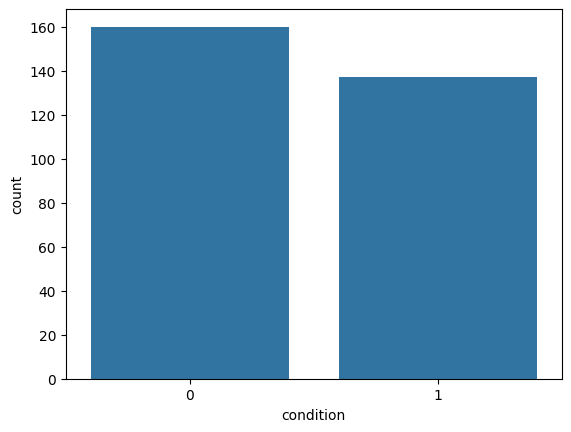

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='condition',data=data)
plt.show()

In [6]:
# Check duplicate values
data.duplicated().sum()

np.int64(0)

In [7]:
data[data.duplicated(keep = False)] # optional since no duplicated were found

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition


In [8]:
# data is Balanced or not
data['condition'].value_counts(1)

,proportion
condition,
0,0.538721
1,0.461279


In [9]:
x=pd.DataFrame(data.iloc[:,:-1])
y=pd.DataFrame(data.iloc[:,-1])

In [10]:
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0


In [11]:
y.head()

,condition
0,0
1,0
2,0
3,1
4,0


In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=2)

In [13]:
# function that found the outlier in data

def CheckOutliers(df):
    columns = [ i for i in df.columns if df[i].dtype != "O"]
    ol= pd.DataFrame({'method':[],'Column':[],'No_of_outliers':[],'Persantage_of_outliers':[]})

    for col in columns:
        if -0.5 < df[col].skew() < 0.5:
            ub = df[col].mean() + (df[col].std())*3
            lb = df[col].mean() - (df[col].std())*3
            outliers = len(df[(df[col] > ub) | (df[col] < lb)][col])
            perchentage_of_Outlier = round((outliers/len(df)) * 100,2)
            temp = pd.DataFrame({'method':['Z-Score'],'Column':[col],'No_of_outliers':[outliers],
                                 'Persantage_of_outliers':[perchentage_of_Outlier]})

            ol = pd.concat([ol,temp]).reset_index(drop = True)

        else:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lw = q1 - 1.5*(iqr)
            uw = q3 + 1.5*(iqr)

            outliers = len(df[(df[col] > uw) | (df[col] < lw)][col])
            perchentage_of_Outlier = round((outliers/len(df)) * 100,2)
            tempp = pd.DataFrame({'method':['IQR'],'Column':[col],'No_of_outliers':[outliers],
                                 'Persantage_of_outliers':[perchentage_of_Outlier]})

            ol = pd.concat([ol,tempp]).reset_index(drop = True)

    return ol

In [14]:
# Function that Found the Outlier index in data both train and test data

def OutlierIndex(df, df1):
    columns = [ i for i in df.columns if df[i].dtype != "O"]
    indexes= []
    test_indexes = []
    for col in columns:
        if -0.5 < df[col].skew() < 0.5:
            ub = df[col].mean() + (df[col].std())*3
            lb = df[col].mean() - (df[col].std())*3

            outlier_index = df[(df[col] > ub) | (df[col] < lb)].index.tolist()
            test_outlier_index = df1[(df1[col] > ub) | (df1[col] < lb)].index.tolist()

            indexes.extend(outlier_index)
            test_indexes.extend(test_outlier_index)

        else:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lw = q1 - 1.5*(iqr)
            uw = q3 + 1.5*(iqr)

            outlier_index = df[(df[col] > uw) | (df[col] < lw)].index.tolist()
            test_outlier_index = df1[(df1[col] > uw) | (df1[col] < lw)].index.tolist()

            indexes.extend(outlier_index)
            test_indexes.extend(test_outlier_index)


    index = set(indexes)
    test_index = set(test_indexes)

    return pd.Series(list(index)), pd.Series(list(test_index))

In [15]:
col_series = x_train.nunique().sort_values(ascending = False)
numeric_data_columns = col_series[col_series>30].index

In [16]:
CheckOutliers(x_train[numeric_data_columns])

,method,Column,No_of_outliers,Persantage_of_outliers
0,IQR,chol,4.0,1.69
1,Z-Score,thalach,0.0,0.00
2,IQR,trestbps,9.0,3.80
3,Z-Score,age,0.0,0.00
4,IQR,oldpeak,2.0,0.84


In [17]:
train_ot_index, test_ot_index = OutlierIndex(x_train[numeric_data_columns],x_test[numeric_data_columns])

In [18]:
# remove outliers from train and test data
x_train.drop(index = train_ot_index, inplace = True)
y_train.drop(index = train_ot_index, inplace = True)

x_test.drop(index = test_ot_index, inplace = True)
y_test.drop(index = test_ot_index, inplace = True)

In [19]:
x_train.shape ,y_train.shape ,x_test.shape ,y_test.shape

((222, 13), (222, 1), (58, 13), (58, 1))

In [22]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
model.fit(x_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [23]:
y_pred = model.predict(x_test)

In [24]:
test_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy: ", test_acc)

Test Accuracy:  0.8103448275862069


In [25]:
precision=precision_score(y_test,y_pred)
print("Precision: ",precision)

Precision:  0.9545454545454546


In [26]:
recall=recall_score(y_test,y_pred)
print("Recall: ",recall)

Recall:  0.6774193548387096


In [27]:
confusion_matrics=confusion_matrix(y_test,y_pred)
print("Confusion Matrix: ",confusion_matrics)

Confusion Matrix:  [[26  1]
 [10 21]]


/tmp/ipython-input-28-3780457846.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=metrics, palette='viridis')


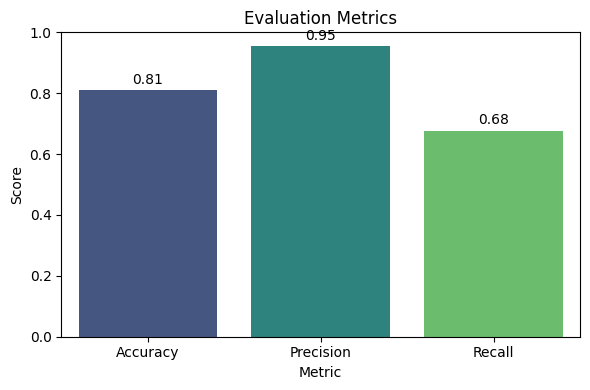

In [28]:
#Bar plot for Accuracy, Precision, and Recall
plt.figure(figsize=(6, 4))
metrics = [test_acc, precision, recall]
names = ['Accuracy', 'Precision', 'Recall']
sns.barplot(x=names, y=metrics, palette='viridis')
plt.ylim(0, 1)
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.xlabel('Metric')
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()

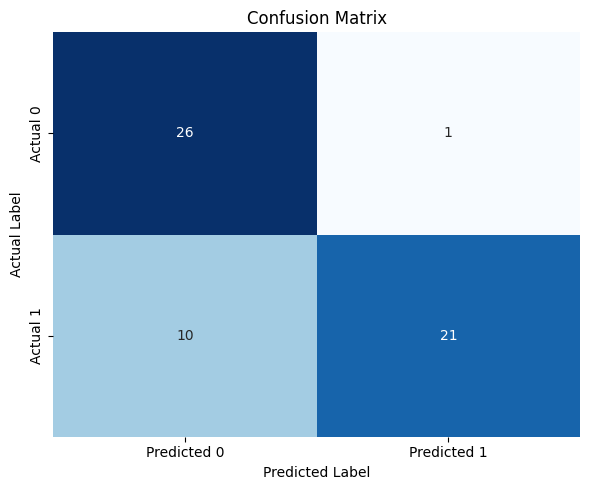

In [29]:
# Heatmap for Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrics, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()